In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
import glob
import pandas as pd
# 先不讀取圖片, 真的要訓練才讀
df = pd.DataFrame(columns=["path", "target"])
for p in glob.glob("train/cat.*.jpg"):
    s = pd.Series([p, 0], index=["path", "target"])
    df = df.append(s, ignore_index=True)
for p in glob.glob("train/dog.*.jpg"):
    s = pd.Series([p, 1], index=["path", "target"])
    df = df.append(s, ignore_index=True)
df

,path,target
0,train/cat.5077.jpg,0
1,train/cat.2718.jpg,0
2,train/cat.10151.jpg,0
3,train/cat.3406.jpg,0
4,train/cat.4369.jpg,0
5,train/cat.7660.jpg,0
6,train/cat.8553.jpg,0
7,train/cat.9895.jpg,0
8,train/cat.1211.jpg,0
9,train/cat.6218.jpg,0


train/cat.10603.jpg
(499, 420)


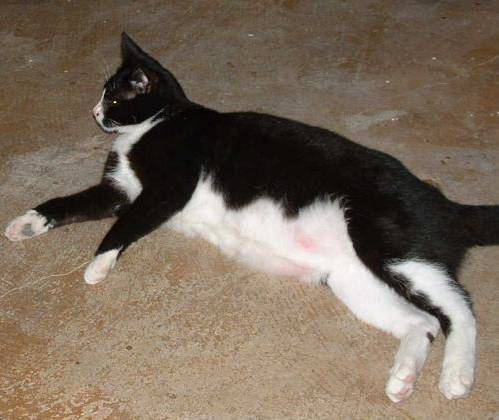

In [4]:
from keras.preprocessing.image import load_img
import random
c = random.randint(0, 24999)
print(df["path"][c])
img = load_img(df["path"][c])
print(img.size)
img

(224, 224)


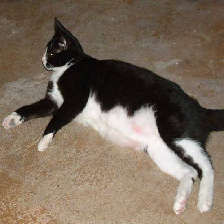

In [5]:
img = load_img(df["path"][c], target_size=(224, 224))
print(img.size)
img

In [6]:
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization
# CNN(眼睛)
for l in vgg.layers:
    l.trainable = False
# BN(血管)
x = BatchNormalization()(vgg.output)
# MLP(大腦)
x = Flatten()(x)
x = Dense(units=2048, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
# 貓和狗分類: units = 1, units = 2 都可以
#         : sigmoid  , softmax
x = Dense(units=2, activation="softmax")(x)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
vgg.layers

In [8]:
cnn.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [9]:
from sklearn.model_selection import train_test_split
# 真的要開始切分和訓練的時候, 請你把你的pandas轉成numpy的array
# 先處理一下答案, 把它轉化成為one-hot
from keras.utils.np_utils import to_categorical
y_cat = to_categorical(df["target"])
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(y_cat),
                                                    test_size=0.1)
# show一個y_train給你看
y_train[-1]

array([0., 1.], dtype=float32)

In [20]:
# 你偷誰的模型, 就要使用他的預處理方式
from keras.applications.vgg16 import preprocess_input
batch_size = 20
for i in range(5):
    # randint(下限(包括), 上限(不包括), 幾個)
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    # numpy好用之處: array[ 索引list ]
    imglist = []
    for fn in x_train[idx]:
        # 讀取圖片並且使用我們偷來的模型的預處理方式來處理一下
        img = load_img(fn, target_size=(224, 224))
        img = preprocess_input(np.array(img))
        imglist.append(img)
    x = np.array(imglist)
    y = y_train[idx]
    result = cnn.train_on_batch(x, y)
    print("-----Times", i, "-----")
    print(result)

-----Times 0 -----
[1.5014136, 0.85]
-----Times 1 -----
[1.9760263, 0.85]
-----Times 2 -----
[2.4177144, 0.85]
-----Times 3 -----
[2.4461155, 0.85]
-----Times 4 -----
[1.2615337, 0.9]


In [21]:
batch_size = 100

# randint(下限(包括), 上限(不包括), 幾個)
idx = np.random.randint(0, x_test.shape[0], batch_size)
# numpy好用之處: array[ 索引list ]
imglist = []
oriimglist = []
for fn in x_test[idx]:
    # 讀取圖片並且使用我們偷來的模型的預處理方式來處理一下
    img = load_img(fn, target_size=(224, 224))
    # 先把原圖留下來
    oriimglist.append(np.array(img))
    img = preprocess_input(np.array(img))
    imglist.append(img)
x = np.array(imglist)
y = y_test[idx]
cnn.evaluate(x, y)


100/100 [==============================] - 35s 345ms/step


[0.9693398475646973, 0.94]

In [22]:
# 作圖(參考)
pre = cnn.predict(x).argmax(axis=-1)
# 拿出預測標籤最大值的索引
pre

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1])

In [23]:
# 拿出正確答案最大值的索引
y.argmax(axis=-1)

array([1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1])

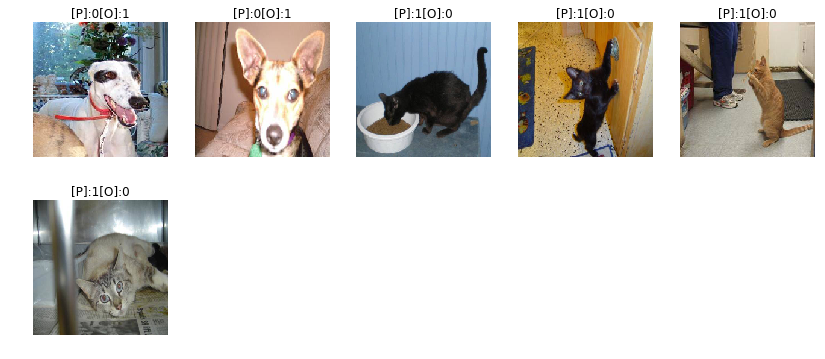

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
idx = np.nonzero(pre != y.argmax(axis=-1))[0]
width = 5
height = int(len(idx) / 5) + 1
plt.figure(figsize=(14, 6))
for (i, img) in enumerate(np.array(oriimglist)[idx]):
    plt.subplot(height, width, i + 1)
    t = "[P]:" + str(pre[idx][i]) + "[O]:" + str(y.argmax(axis=-1)[idx][i])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)